<a href="https://colab.research.google.com/github/wet-meadow/learn/blob/main/MyceliumMassPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this

Here's an example of creating a predictive **regression** model for the mass of mycelium that we should harvest given what we know about a run.  We'll start super simple and increase the sophistication as we go.  Our first models will be pretty bad.

Don't get discouraged we'll get it better. 😀

Resources:
* [Scikit learn](https://scikit-learn.org/stable/) - Easy mode for ML
* [Pandas reference](https://pandas.pydata.org/docs/getting_started/index.html) - Your friend for data manipulation
* [Seaborn](https://seaborn.pydata.org/) - A handy plotting package

## Setup and Helpers

📓 For simplicity we'll use my token for QB.  Gaurd it vigorously!  😀

In [ ]:
#@title
# Copy from Dylan!
!pip install quickbase-client
!pip install getpass4

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import getpass
import os

# For interactive data tables
from google.colab import data_table
data_table.enable_dataframe_formatter()


# Outputs a prompt for you to enter your token directly into
# os.environ["QB_TOKEN"] = getpass.getpass("QB Token")
# QB_USER_TOKEN = os.environ["QB_TOKEN"]

QB_USER_TOKEN = 'b5wabd_pgpa_0_d67cqzmbhi4g88djz5iv6c4wjbz'
os.environ["QB_TOKEN"] = QB_USER_TOKEN

# Just run this once per session.
GCRUNS_TABLE_ID = "br2ve9zca"
TEXTILE_HARVEST_TABLE_ID = "bs964xfww"
HARVEST_TABLE_ID = "br3xqbu9h"
SPECIMENS_TABLE_ID = "bta46zpha"
# !qbc run model-generate -a https://ecovative.quickbase.com/db/bry8puty5 -t {QB_USER_TOKEN} # get all tables as models
!qbc run model-generate -a https://ecovative.quickbase.com/db/bry8puty5 -t {QB_USER_TOKEN} -i {GCRUNS_TABLE_ID} -i {TEXTILE_HARVEST_TABLE_ID} -i {HARVEST_TABLE_ID} -i {SPECIMENS_TABLE_ID}

#@title
from quickbase_client.query.query_base import QuickbaseQuery
from quickbase_client import QuickbaseTableClient, QuickBaseTable
from pprint import pprint
import pandas as pd

def get_df_from_object(data, table_schema, fields_present):
    fields = {attr_value.fid: attr_name for attr_name, attr_value in table_schema.__dict__.items() if attr_value.fid in fields_present}
    df = pd.DataFrame({fields[fid]: [getattr(textile_panel, fields[fid]) for textile_panel in data] for fid in fields_present})
    return df

def get_report_from_name(table: QuickBaseTable,
                         report_name: str,
                         user_token: str = None):
  if user_token is None:
    user_token = QB_USER_TOKEN
  client = table.client(user_token)
  reports = client.get_reports_for_table()
  report = [r for r in reports.json() if r["name"] == report_name]
  try:
    return report[0]
  except IndexError as ex:
    raise ValueError("Report with specified name not found.") from ex

def get_report(table, report_name, user_token: str = None, return_df=True):
  if user_token is None:
    user_token = QB_USER_TOKEN
  client = table.client(user_token)
  report = get_report_from_name(table, report_name, user_token=user_token)
  report_query = report["query"]
  query = QuickbaseQuery(
      where=report_query.get("where"),
      options=report_query.get("options"),
      group_by=report_query.get("groupBy"),
      sort_by=report_query.get("sortBy"),
      select=report_query.get("fields"),
  )
  data = client.query(query)
  if return_df:
    return get_df_from_object(data, table.schema, report["query"]["fields"])
  return data

sam = {"Advice" : "R^2 of close to 100% is suuuuuus!"}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running...
string index out of range
	rerun with qbc --show-stacktrace for more output
	example: qbc --show-stacktrace run blah


In [ ]:
!zip -r models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/record_keeping/ (stored 0%)
  adding: content/models/record_keeping/run.py (deflated 80%)
  adding: content/models/record_keeping/app.py (deflated 36%)
  adding: content/models/record_keeping/textile_panel.py (deflated 76%)
  adding: content/models/record_keeping/__init__.py (stored 0%)
  adding: content/models/record_keeping/specimen.py (deflated 77%)
  adding: content/models/record_keeping/food_panel.py (deflated 81%)
  adding: content/models/__init__.py (stored 0%)


## Get our Data:
An artesanally hand crafted "Report" is [built here](https://ecovative.quickbase.com/db/br3xqbu9h?a=q&qid=45).  Weve selected some choice features for you. And yes, the data is always fresh. 😋

And using Dylan's handy helper functions this becomes 2 lines of code!  Thank you Dylan!  🤜 🤛

In [ ]:
from models.record_keeping.food_panel import FoodPanel

report_name = "Fill Weight and Food panel Mass" # Line 1
df_all = get_report(FoodPanel, report_name)     # Line 2

In [ ]:
df_all.info() # Looks like we have some empty entries....
# ... and some pretty unweildy column names....
# 'related_tray_record_gc_run_treatment_actual_fill_weight' really?!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5397 entries, 0 to 5396
Data columns (total 8 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   tray_record_full_panel_id                                   5397 non-null   object 
 1   related_tray_record_run_treatment_actual_fill_weight        1192 non-null   float64
 2   related_tray_record_run_treatment_average_packing_moisture  1442 non-null   float64
 3   related_tray_record_run_biopolymer_application              5397 non-null   object 
 4   related_tray_record_run_chamber_name                        5397 non-null   object 
 5   related_tray_record_run_treatment_format                    5397 non-null   object 
 6   run_date_of_extraction_planned                              5183 non-null   object 
 7   wet_mass_g                                                  1949 non-null   float64
dtyp

In [ ]:
columns_to_keep = ['tray_record_full_panel_id','related_tray_record_run_treatment_actual_fill_weight','wet_mass_g']
df = df_all[columns_to_keep]                              # Selecting just the columns to focus on
df.columns = ['Panel ID', 'Fill Weight', 'Harvest Mass']  # Let's rename the columns
df = df.dropna()                                          # And drop records that are missing data
display(df.info())                                        # Get some summary information
df


<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 1287 to 3515
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Panel ID      763 non-null    object 
 1   Fill Weight   763 non-null    float64
 2   Harvest Mass  763 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.8+ KB


None

,Panel ID,Fill Weight,Harvest Mass
1287,RAF19G_R11A,1119.0,276.0
1288,RAF19G_R12D,1204.0,238.0
1289,RAF19G_R26E,1200.0,264.0
1290,RAF19G_R12B,1279.0,233.0
1291,RAF19G_R12A,1215.0,228.0
...,...,...,...
3511,FAE25I_R12A,4201.0,913.0
3512,FAE25I_R13C,4969.0,871.0
3513,FAE25I_R15A,4969.0,872.0
3514,FAE25I_R16A,4201.0,771.0


## Pop Quiz!
Use the code box below to make a scatter plot with `Fill Weight` on the x-axis and `Haverst Mass` on the y-axis.

In [ ]:
# You can do it!


Quiz Answers

<Axes: xlabel='Fill Weight', ylabel='Harvest Mass'>

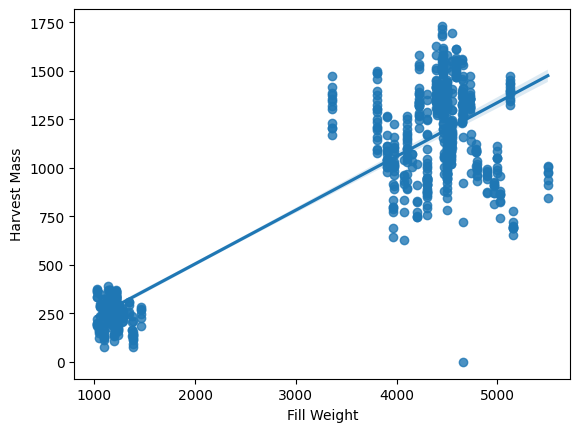

In [ ]:
#@title
# Time to make a quick plot of the data
import seaborn as sns # I like this plotting package
# plt.scatter(x=df['Fill Weight'], y=df["Harvest Mass"]) #straight matplotlib
# df.plot.scatter(x="Fill Weight", y="Harvest Mass") # using pandas
# sns.scatterplot(data=df, x='Fill Weight', y='Harvest Mass') # using seaborn
sns.regplot(data=df, x='Fill Weight', y='Harvest Mass') # seaborn cheat mode

# 1. Appetizer: Simple Regression

Simple regression just means we have one input and one output.  In this example will use data right from the harvest table. `Harvest`

* X: Fill Weight `related_tray_record_gc_run_treatment_actual_fill_weight`
* Y: Harvest Weight `wet_mass_g`
* Model: Some form of regression

Steps:
1. Fit a model
1. Make some predictions
1. Evalute it (*spoiler:* it's not great!) 😆

## Fit a simple model



In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # Get a model object
X = df['Fill Weight'].values.reshape((-1,1)) # Define X and make it a numpy array with the right shape
y = df['Harvest Mass'].values.reshape((-1,1)) # The same for y
model.fit(X, y) # Fit the model
y_pred = model.predict(X) # Make predictions
df['Harvest Mass (pred)'] = y_pred # Store them in your dataframe... why not!

## Evaluate the model

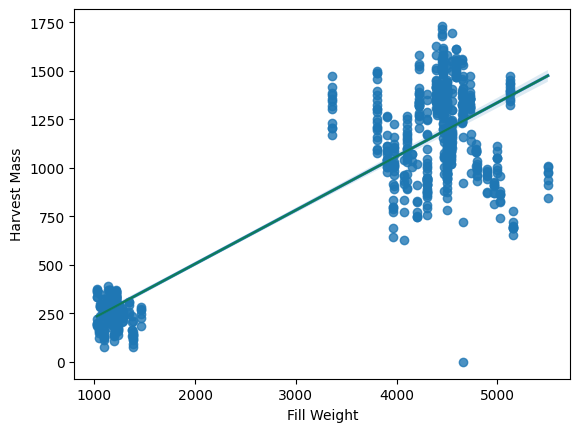

In [ ]:
# Start by plotting the data and the fit results
sns.regplot(data=df, x='Fill Weight', y='Harvest Mass')
sns.lineplot(data=df, x='Fill Weight', y='Harvest Mass (pred)', color='green', alpha=0.5)
plt.show()

## Making a single prection

The `model.predict()` method will take a big array of inputs or a single input (still as an array) and happily give predictions.  What is the predicted mass for a tray filled with 2000 grams of substrate?

In [ ]:
new_mass = np.array([2000]).reshape(-1,1)
prediction = model.predict(new_mass)
print(f"With {new_mass[0][0]:.0f}g of substrate, you should expect to harvest {prediction[0][0]:.0f}g of mycelium")

With 2000g of substrate, you should expect to harvest 505g of mycelium


## Is this model any good?

These models can give their own report cards, using the `model.score()` method.  In this case it returns the R^2 metric that you likely know and love.

From the image above it looks like there is a good amount of error.  The R^2 is 0.79.  Not terrible, but still not very good.

In [ ]:
r_2 = model.score(X,y)
print(f"This model has an R-squared of: {r_2:.1%}")
first_r_2 = r_2 # save this for later

This model has an R-squared of: 77.7%


# First Course: Regression with Multiple Continuous Variables

Next we'll see if giving the model more X's can help make the model better.  There are all sorts of things we already know that we could use to make a more accurate and robust model.

A good approach is to pick some more X's ("Features"). But we're only ready for other continuous numeric features. Something with a Dtype of `float64` should work. Let's go 'shopping' for some.



## Feature Selection

In [ ]:
# Let's look at the options.
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5397 entries, 0 to 5396
Data columns (total 8 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   tray_record_full_panel_id                                   5397 non-null   object 
 1   related_tray_record_run_treatment_actual_fill_weight        1192 non-null   float64
 2   related_tray_record_run_treatment_average_packing_moisture  1442 non-null   float64
 3   related_tray_record_run_biopolymer_application              5397 non-null   object 
 4   related_tray_record_run_chamber_name                        5397 non-null   object 
 5   related_tray_record_run_treatment_format                    5397 non-null   object 
 6   run_date_of_extraction_planned                              5183 non-null   object 
 7   wet_mass_g                                                  1949 non-null   float64
dtyp

In [ ]:
# You can select them by name like this:
columns_to_keep = ['related_tray_record_run_treatment_actual_fill_weight',
                   'related_tray_record_run_treatment_average_packing_moisture',
                   'wet_mass_g']
df = df_all[columns_to_keep]

# Or in one line, you can do this
df = df_all.select_dtypes('float')

# Drop the null records
df = df.dropna()

# We still want some easier column names
df.columns = ['Fill Weight', 'Substrate Moisture', 'Harvest Mass']

In [ ]:
display(df.info())
display(df.describe())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 1287 to 3515
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fill Weight         624 non-null    float64
 1   Substrate Moisture  624 non-null    float64
 2   Harvest Mass        624 non-null    float64
dtypes: float64(3)
memory usage: 19.5 KB


None

,Fill Weight,Substrate Moisture,Harvest Mass
count,624.000000,624.000000,624.000000
mean,3431.833333,73.554893,874.525641
std,1557.590863,7.471369,475.931398
min,1026.000000,61.015000,-1.000000
25%,1246.000000,65.670000,288.750000
50%,4300.000000,77.440000,996.000000
75%,4538.000000,80.373333,1306.000000
max,5500.000000,84.036667,1695.000000


,Fill Weight,Substrate Moisture,Harvest Mass
1287,1119.0,64.260000,276.0
1288,1204.0,66.780000,238.0
1289,1200.0,64.350000,264.0
1290,1279.0,66.030000,233.0
1291,1215.0,66.570000,228.0
...,...,...,...
3511,4201.0,66.673333,913.0
3512,4969.0,65.286667,871.0
3513,4969.0,65.286667,872.0
3514,4201.0,66.673333,771.0


Let's make some plots to scan for relationships that might make sense and to see if there are outliers in our data.

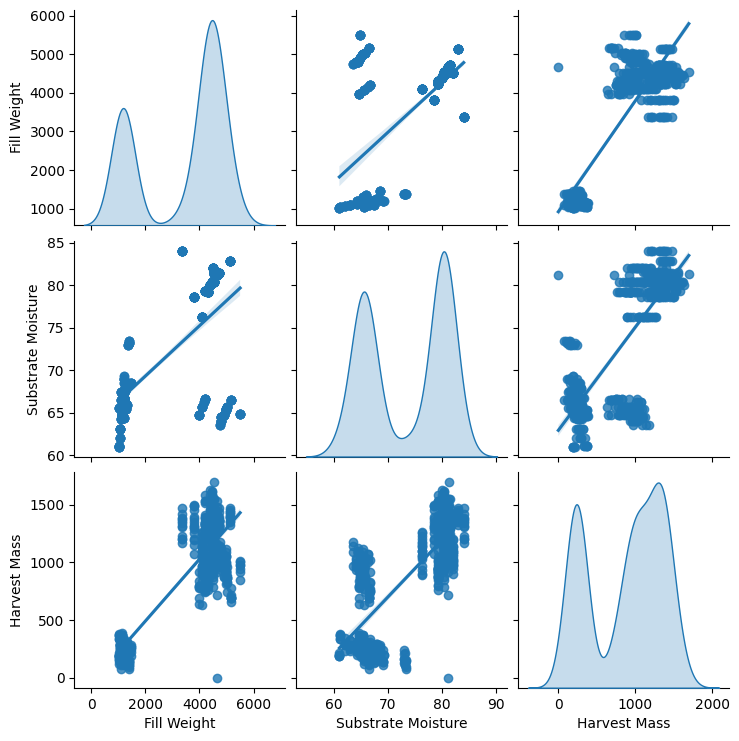

In [ ]:
# We can plot each pairing of features and labels separately like this
# fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(10,2))
# sns.regplot(data=df, x='Fill Weight', y='Harvest Mass', ax=axs[0])
# sns.regplot(data=df, x='Substrate Moisture', y='Harvest Mass', ax=axs[1])

# "Easy Mode" use this shortcut with seaborns 'pairplot'
sns.pairplot(data=df, kind='reg', diag_kind='kde')

## 🔥 Fit a Model

Now that we have selected our new feature set, by adding in the Substrate Moisture, we can repeat what we did last time... but now with more features.

In [ ]:
# Pick our type of model
model = LinearRegression()

# Make the X and y's
x_cols = ['Fill Weight', 'Substrate Moisture']
y_col = 'Harvest Mass'
X = df.loc[:,x_cols].values
y = df.loc[:,y_col].values.reshape(-1,1)

# Fit it!
model.fit(X,y)

# Store predictions
y_pred = model.predict(X)
df['Harvest Mass (pred)'] = y_pred

# Calculate your score
second_r_2 = model.score(X, y)
print(f"This model has an R-squared of {second_r_2:.1%}")

This model has an R-squared of 85.6%


Hooray!  We have a slightly less bad model!  😆

Let's take a closer look. When we have more than one variable it's helpful to simply plot the actual labels vs. the predicted label.  If your really accounts for the variability in the data the points should all fall near diagonal.

In this case we still are missing a lot the variability.

<Axes: xlabel='Harvest Mass', ylabel='Harvest Mass (pred)'>

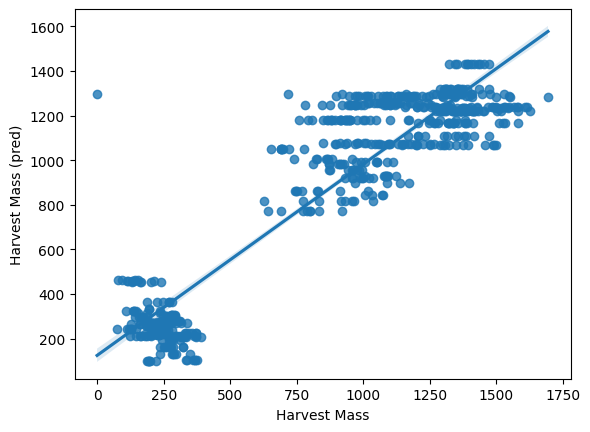

In [ ]:
sns.regplot(data=df, x='Harvest Mass', y='Harvest Mass (pred)')

The linear model is going to fit for two coefficients and one intercept.

The formula will look like
` y = k1*x1 + k2*x2 + b` where `x1` is the Fill Weigh, and `x2` is the Substrate Moisture and `b` is the intercept.

We can see what those are with the `model.coef_` parameter and the `model.intercept_` parameter

In [ ]:
display(model.coef_)
display(model.intercept_)

# Let's write out the formula
print(f"y = {model.coef_[0][0]:.2f} * [Fill Weight in grams] + {model.coef_[0][1]:.2f} * [Subtrate Moisture (0-100)] + {model.intercept_[0]:.2f}")

array([[ 0.19806248, 23.6897628 ]])

array([-1547.68975598])

y = 0.20 * [Fill Weight in grams] + 23.69 * [Subtrate Moisture (0-100)] + -1547.69


## 👀 Cautions on using lots of features
Now that we have the ability to fit against more than one feature we'd be tempted to train a model with ALL of the avialable features.  If 2 is better than 1 then 100 is WAYYY better than 2, right?  🤔

Maybe!  But you also can fall into some common data traps 🪤 when you run fast and hard.

* **Duplication**: Sometimes two features can actually give you the same information.  Imagine a column like "substrate depth (in)" and "substrate depth (cm)".  They may duplicate the actual information present.
* **Dependency** Sometimes features are combine together and don't add new information.  Imagine colums with height, width, depth, area, volume, mass, density.  None of these are independent from each other, so adding them all can actually give loewer quality results.
* **Scale** Including columns with numbers like 1e14, 10, and 1e-26 have vastly different scales.  This can create imbalance in a model.
* **Variance** Your data may have very little spread in some dimensions.  If they haven't covered much range, then they dont add much value.

In the next session will use some tools to handle these kinds of real world data challenges.


## Conclusion

Now you can make a linear model and evaluate it for an arbitrary number of features!  🚀. Congratulations!  **"With great power comes great responsibility"**

* But what do we do when we don't know if a linear model is a good choice for our application?
* What if we want to make use of numerical AND categorical features for our models.  Are we out of luck?

Now... prepare for more super powers.  🦸

# Second Course: Non-linear Models

Here's we'll look at one of my go-to first cracks at a model.  It's called a "Random Forest" and it uses a decision tree approach.  We'll even use something called an "**Extreme** Gradient Boosted Randmom Forest Regression Model"

Fancy!🎩


## Feature selection

Wouldn't it be nice to be able to use some of the other features that we have ready access to, to improve our model?

But they aren't numeric!  They are `object` types. Not to worry. A decision tree doesn't care too much.

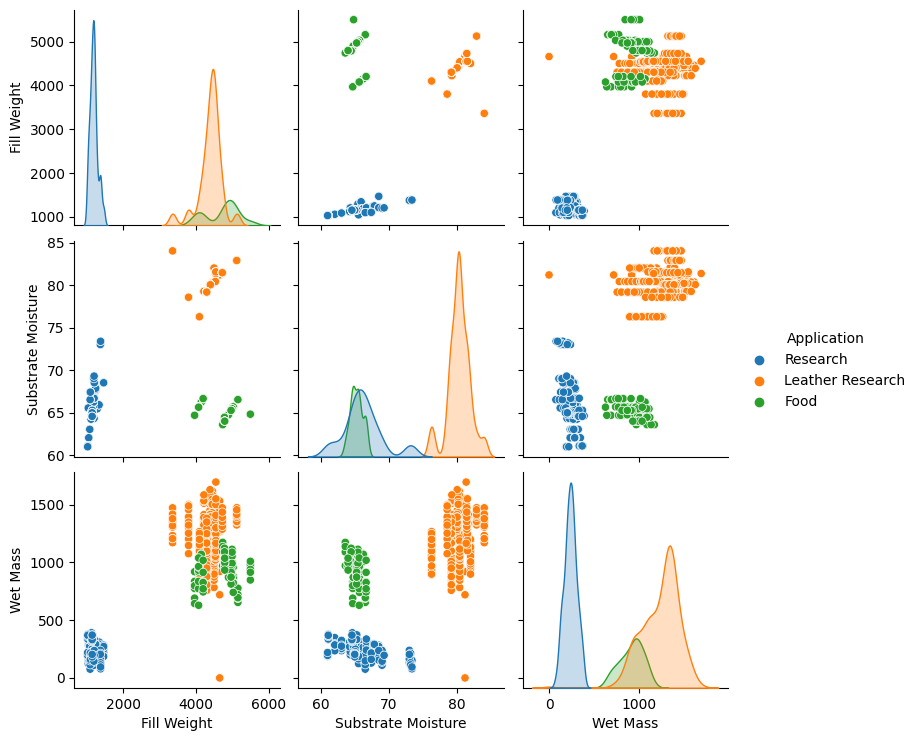

In [ ]:
df = df_all.dropna()
# df.info()
df.columns = ['Panel Id', 'Fill Weight', 'Substrate Moisture', 'Application', 'Chamber Name', 'Tray Format', 'Harvest Date', 'Wet Mass']
sns.pairplot(df, hue='Application')

Let's look at "Application" first.  Seems reasonable to say if we know the application ahead of time we could do a better job of predicting the mass.  Looking at the lower right chart below that as it relates to Wet Mass, the different applications certaily are "Seperable" (the distribution of each population has minimal overlap). That's a good sign that this would be a helpful feature.

## About Random Forest Models

Random Forest Models are different than linear regression models in a number of important ways.

### Compare and Contrast
* It does not require that you assume that the outputs are linear to the features.
* It can handle mixed types of data (categories and numbers can live in harmony together) 🕊
* It is capable of being "over-fit", so requires that we modify our 'pre-processing'.
* It can be used for both Regression and Classification tasks.
* Is often difficult to interpret / explain the outputs.  More on this later!

### Basic Principal
A Random Forest is a type of **Decision Tree** approach. Think of this as generating a lot of fixed estimates based on a set of conditions for a feature. Let's build a decision tree by ourselves to get the hang of it:

Proposal:
  * Let's split our observations in to trays filled with more than 2.5kg and trays filled with less than 2.5kg.
  * Then lets split those observations into Research Runs, Leather Runs, Food Runs etc.
  * Then lets split those into substrate moisture contents great than 80%.
  * If I apply all those splits my expected value approaches the average of my observations that meet those conditions."

That example is one "Tree" 🌲.

What's a Random Forest (of Trees)?

A random forest is the process of making LOTS of these trees and using the results of all the decision trees to give an output.  It's "random" in that it gives a little bit of different samples of data to each of the trees to avoid coming up with lots of trees that give the same answer.

What does it mean to Train a Random Forest Model?

To train a decision tree is to iteratively select the order in which you evaluate your features, and the thresholds for each branch such that you minimize some error function.

To train a FOREST is to add the selection which features each tree has to consider, such that the ensemble decision minimizes some error.

What's the deal with "Extreme Gradient Boosting"?

This is an 'under the hood' implementation that allows the random forest training process run much more efficiently and reliably.  This particular implementation has become the gold standard of using these models.

Enough!  Let's code!

👀 **Look Familiar?**
1. Model
1. Fit
1. Predict
1. Score


The Random Forest model R^2 is 95.1% vs. the last linear model of 85.6%


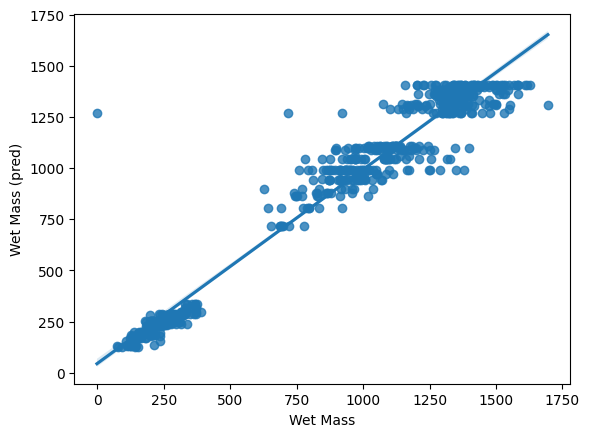

In [ ]:
from xgboost import XGBRFRegressor

# Start with just the numeric features
df_numeric = df.select_dtypes('float').dropna()

# Define X and y
X, y = df_numeric.iloc[:,:-1], df_numeric.iloc[:,-1]

# Define the model
model = XGBRFRegressor()
# Or with custom parameters
# model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# Fit the model
model.fit(X,y)

# Save your predictions
df_numeric['Wet Mass (pred)'] = model.predict(X)

# Score the model
r2_xgb = model.score(X, y)

print(f'The Random Forest model R^2 is {r2_xgb:.1%} vs. the last linear model of {second_r_2:.1%}')
sns.regplot(data=df_numeric, x='Wet Mass', y='Wet Mass (pred)')
plt.show()

Let's REALLY study this plot and see what we notice.

Is there anything a little weird about it?

If so, what does that tell us about the **model**?  What does it tell us about our **metric**?

In [ ]:
#@title
# HINT:  There is some "horizontal banding" in the predictions.  There are whole sets of data point where the prediction is the same value despite the actual values varying quite a bit.

# HINT:  For a nearly perfect score, the error range looks pretty big!  What gives?

## Overall, is this model good?

An R2 of 95%+ looks great.... on the surface.

But, remember what Sam said? 🤔



In [ ]:
print(sam['Advice'])

R^2 of close to 100% is suuuuuus!


So what has happened? How come our score became extremely high?

Well, one issue is that we may have made a *cardinal mistake* in machine learning called [**OVERFITTING**](https://en.wikipedia.org/wiki/Overfitting)

When we trained this model we trained it with all of the available data.  I really complex model can esentially *memorize* the best answers for any set of inputs you give it. This can happen in many types of machine learning tasks, not just regression.

When we overfit a model it becomes super good at telling you what was in the data it was trained on... and really bad at predicting the results of new data.

The second issue is that our **metric** may not be aligned with what we care about.  Let's handle overfitting first.

## Avoiding Overfitting

The first step in avoiding overfitting is to hold back some of your data at the time that you train the model, and then to test the trained models accuracy on the data that you've withheld.

The logic is this "If you haven't overfit, your model should be as good with the training data as it is with the test data"

If the model is awesome on training data and worse on test data then you've overfit.

The common pattern is to split your data (thoughtfully) **training data** and **testing data**.

Let's give it a try!

In [ ]:
from sklearn.model_selection import train_test_split

# Start with just the numeric features
df_numeric = df.select_dtypes('float').dropna()

# Randomly assign 80% of the data to train and 20% to test
train, test = train_test_split(df_numeric, test_size = 0.2,
                               random_state=3, # Picking a random 'seed'
                               )

In [ ]:
print(f'We have {len(df_numeric)} records to work with')
print(f'After splitting we have {len(train)} in train, and {len(test)} in test')

We have 624 records to work with
After splitting we have 499 in train, and 125 in test


In [ ]:
# Start with just the numeric features
df_numeric = df.select_dtypes('float').dropna()

# Randomly assign 60% of the data to train and 40% to test
train, test = train_test_split(df_numeric, test_size = 0.4,
                               random_state=3, # Picking a random 'seed'
                               )
# Define X and y
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

# Define the model
model = XGBRFRegressor()
# Or with custom parameters
# model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# Fit the model
model.fit(X_train,y_train)

# Save your predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Score the model
r2_xgb_train = model.score(X_train, y_train)
r2_xgb_test = model.score(X_test, y_test)

print(f'The train R^2 is {r2_xgb_train:.1%} vs. a test R^2 {r2_xgb_test:.1%}')
# sns.regplot(data=, x='Wet Mass', y='Wet Mass (pred)')
# plt.show()

The train R^2 is 96.7% vs. a test R^2 92.2%


**Q:** How does overfitting change with the split size?  How do I know what to pick?

**A:** 60/40, 70/30, 80/20 are typical choices.  In a pinch use, one of these

**TLDR** Test a range of them and see what minimizes the difference between train and test scores.  (exmaple plot next)

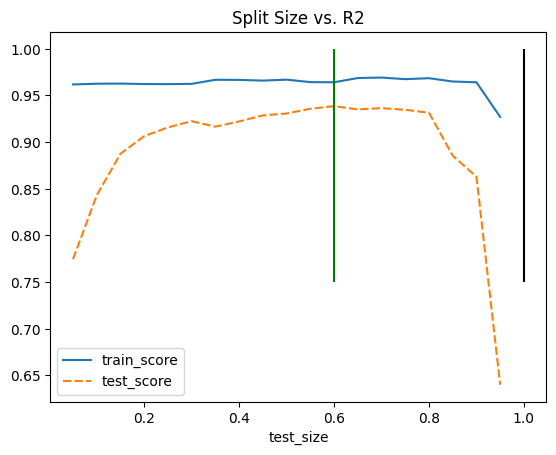

In [ ]:
#@title
def splits_vs_r2(df, test_size):
  # Start with just the numeric features
  df_numeric = df.select_dtypes('float').dropna()

  # Randomly split according to `test_size`
  train, test = train_test_split(df_numeric, test_size=test_size,
                                random_state=3, # Picking a random 'seed'
                                )
  # Define X and y
  X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
  X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

  # Define the model
  model = XGBRFRegressor()
  # Or with custom parameters
  # model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

  # Fit the model
  model.fit(X_train,y_train)

  # Save your predictions
  y_train_pred = model.predict(X_train)

  # Score the model
  r2_xgb_train = model.score(X_train, y_train)
  r2_xgb_test = model.score(X_test, y_test)
  return r2_xgb_train, r2_xgb_test

# loop through split sizes and record the scores
split_data = []
test_sizes = np.arange(0.05,1,.05).tolist()
for test_size in test_sizes:
  tr, te = splits_vs_r2(df, test_size)
  split_data.append({'test_size': test_size,
                     'train_score': tr,
                     'test_score': te})
split_data = pd.DataFrame(split_data).set_index('test_size')

# plot the results
g = sns.lineplot(data=split_data)
plt.vlines(x=[0.6,1], ymin=.75, ymax=1, colors=['green', 'black'])
g.set(title='Split Size vs. R2')
plt.show()

MORE ADVANCED:  This is good, but we still are a bit at the whim of what particular data was randomly assigned to the training data and which was assigned to the test data.  For a robust handling of this take a look at implementing something called ["cross validation"](https://scikit-learn.org/stable/modules/cross_validation.html) .  This will output a range of scores depending on how the data was selected and give you a sense for an "average" score as well as tell you how sensitive your model is to the particular data split.  A good setup should have a high average score AND not vary a lot for different randomization.


In [ ]:
from sklearn.model_selection import cross_val_score
df_numeric = df_numeric.sample(frac=1) # Need to shuffle before cross-validation
X = df_numeric.iloc[:,:-1]
y = df_numeric.iloc[:,-1]
scores = cross_val_score(model, X, y, cv=5) #cv=3 splits the data into 4 groups of 66/33
print(f"The cross validated score is: {scores.mean():.1%}")
print(scores)

The cross validated score is: 94.4%
[0.96836018 0.95795914 0.88354818 0.95569086 0.95480097]


🚀 Now we have a model that is trained that does better than an equivalent multiple linear regression model!  Our R2 has gone from 77% to 86% and now to 94%+. 🥳.

BUT.... We still have the issue where the error in predictions seems unacceptably large, even if the R2 value is great.

## Metrics

R2 is could for assessing the confidence that there is a linear relationship between some variables. But what we actually want to do is measure something related to accuracy.  For that we can go to a library of metrics and choose what makes sense for our application.  Sci-kit Learn has a [great resource on the topic](https://scikit-learn.org/stable/modules/model_evaluation.html)

In this case since we're concerned about **accuracy** and we're doing a **regression problem** a good choice might be `sklearn.metrics.mean_squared_error`

Remember that the 95% confidence interval is +/- 2*ROOT Mean Squared Error.  See the [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule#:~:text=For%20an%20approximately%20normal%20data,deviations%20account%20for%20about%2099.7%25.)

mean_error=-13.8g
mse=17353.4g^2
rmse=131.7g


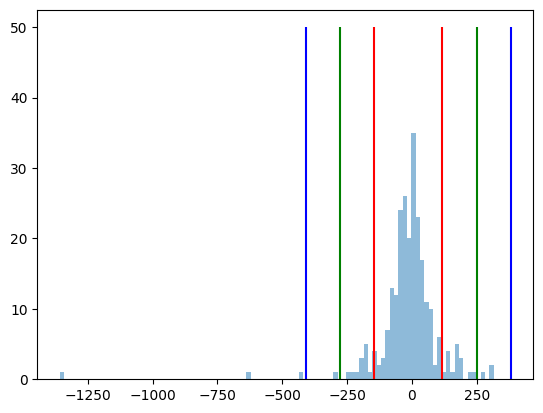

In [ ]:
# First calculate the error metrics by 'hand'

# Residuals are the difference between actual and prediction
res = y_test - y_test_pred

# Plot a histogram of the residuals
plt.hist(res, bins=100, alpha=.5)

# The mean of the residuals tells you if there is bias
mean_error = res.mean()
print(f"{mean_error=:.1f}g") #close to zero?

# The mean of the square of the errors ~= variance
mse = (res**2).mean()
print(f"{mse=:.1f}g^2") # the variance

# The square root of the mean of the square of the errors ~= standard deviation
rmse = mse**(1/2)
print(f"{rmse=:.1f}g")

# Show the confidence bounds
plt.vlines(x=[mean_error-rmse, mean_error+rmse], ymin=0, ymax=50, colors='red')
plt.vlines(x=[mean_error-2*rmse, mean_error+2*rmse], ymin=0, ymax=50, colors='green')
plt.vlines(x=[mean_error-3*rmse, mean_error+3*rmse], ymin=0, ymax=50, colors='blue')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# Use sklearns built in error metric for MSE
mse = mean_squared_error(y_true=y_test,
                         y_pred=y_test_pred,
                         )
# Then get RSME
rmse = mse**(1/2)

# Or in one step
rmse = mean_squared_error(y_true=y_test,
                          y_pred=y_test_pred,
                          squared=False, # This gives you the 'root'
                          )

print(f"The RMSE is {rmse=:.1f}g")
print(f"Uncertainty at 95% is approximately +/-{2*rmse:.1f}g")

The RMSE is rmse=131.7g
Uncertainty at 95% is approximately +/-263.5g


Ok - Where are we?  We've got a random forest model that is not overfit 🎉 AND we have a metric that is more aligned to our task on accuracy 🎉

But the accuracy is not awesome.  My predictions on a 1kg panel could be anywhere from 750g to 1,250g.  We can do better.

Now!  More FEATURES

## Adding Categorical + Numeric Features

In [ ]:
# Let's just go for it!!!

train, test = train_test_split(df, test_size=0.4)
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

model = XGBRFRegressor(objective="reg:squarederror")
model.fit(X_train, y_train) # <--- Generates an ERROR!!

ValueError: ignored

Ok - so the data needs to be manipulated for this to work.  It doesn't know how to deal with something like "Leather Application" without a little help.

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5397 entries, 0 to 5396
Data columns (total 8 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   tray_record_full_panel_id                                   5397 non-null   object 
 1   related_tray_record_run_treatment_actual_fill_weight        1192 non-null   float64
 2   related_tray_record_run_treatment_average_packing_moisture  1442 non-null   float64
 3   related_tray_record_run_biopolymer_application              5397 non-null   object 
 4   related_tray_record_run_chamber_name                        5397 non-null   object 
 5   related_tray_record_run_treatment_format                    5397 non-null   object 
 6   run_date_of_extraction_planned                              5183 non-null   object 
 7   wet_mass_g                                                  1949 non-null   float64
dtyp

In [ ]:
df = df_all.dropna()
# Define some columns to work with
y_col = ['wet_mass_g']
num_cols = ['related_tray_record_run_treatment_actual_fill_weight',
                'related_tray_record_run_treatment_average_packing_moisture']
cat_cols = ['related_tray_record_run_biopolymer_application',
            'related_tray_record_run_chamber_name',
            'related_tray_record_run_treatment_format', # Causes an ERROR
            # 'tray_record_full_panel_id', # <--- UNIQUE IDS carefull!!
            # 'run_date_of_extraction_planned', # <-- DATES not yet!!
            ]
x_cols = num_cols+cat_cols
df[cat_cols] = df[cat_cols].astype('string') # Not a good way to do this


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


pipeline = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        # ("num", StandardScaler(), num_cols), #We can define more transforms...
    ],
    remainder="passthrough",
)
encoder = pipeline.fit(df[x_cols])
X_t = encoder.transform(df[x_cols])
print(f'We encoded the X data from {df[x_cols].shape} to {X_t.shape}')

We encoded the X data from (624, 5) to (624, 13)


The new R2 is 94.4%
The 95% CI is +/- 224.0g


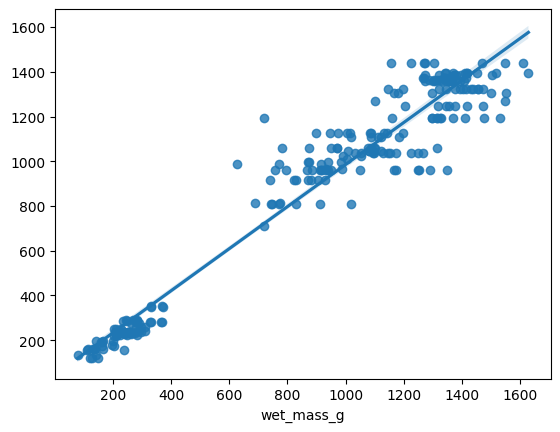

In [ ]:
# Normal Train Test Split
train, test = train_test_split(df, test_size=0.4, random_state=0)
X_train = encoder.transform(train[x_cols]) # <-- Encoded now
y_train = train.iloc[:,-1]
X_test = encoder.transform(test[x_cols]) # <-- Encoded now
y_test = test.iloc[:,-1]

# FIT
model.fit(X=X_train, y=y_train)

# PREDICT
y_test_pred = model.predict(X_test)

# SCORE
r2_xgb_mixed = model.score(X_test, y_test)

rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"The new R2 is {r2_xgb_mixed:.1%}")
print(f"The 95% CI is +/- {2*rmse:.1f}g")
sns.regplot(x=y_test, y=y_test_pred)
plt.show()

## Next Steps

